In [10]:
#!pip install matplotlib xarray netCDF4 numpy

In [11]:
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import numpy as np

In [12]:
"""
Read MicroHH statistics and settings.
"""
plot_ensemble = True

def xr_read_groups(nc_file, groups=['default'], decode_times=True):
    """
    Read all NetCDF groups into a single Dataset.
    """
    dss = [xr.open_dataset(nc_file, decode_times=decode_times)]
    for group in groups:
        dss.append(xr.open_dataset(nc_file, group=group, decode_times=decode_times))
    return xr.merge(dss)

stat = xr_read_groups('moser180.default.0000000.nc', groups=['default', 'budget'], decode_times=False)

# Statistics calculated as mean over last hour, and only for lower half channel.
z_half = float(stat.zh[-1])/2
stat = stat.sel(time=slice(3600, 7200), z=slice(0, z_half), zh=slice(0, z_half))

# Derived quantities.
stat['U'] = np.sqrt(stat.u**2 + stat.v**2)
stat['ustar'] = (stat.u_flux[:,0]**2)**0.25

# Average statistics in time.
statm = stat.mean(dim='time')

# Read the viscosity.
with open('moser180.ini') as f:
    for line in f:
        if line.split('=')[0]=='visc':
            visc = float(line.split('=')[1])

# Dimensionless height.
ustar = float(statm.ustar)
yplus  = stat.z.values  * ustar / visc
yplush = stat.zh.values * ustar / visc

print(f'Re_tau = {ustar/visc:.2f}')

Re_tau = 179.08


In [13]:
"""
Read reference data Moser.
From: https://turbulence.oden.utexas.edu/data/MKM/
"""

moser_mean = np.loadtxt("chan180.means", skiprows=25)
moser_rey  = np.loadtxt("chan180.reystress", skiprows=25)
moser_u2   = np.loadtxt("chan180.uubal", skiprows=25)
moser_v2   = np.loadtxt("chan180.wwbal", skiprows=25)
moser_w2   = np.loadtxt("chan180.vvbal", skiprows=25)
moser_tke  = np.loadtxt("chan180.kbal", skiprows=25)
moser_uw   = np.loadtxt("chan180.uvbal", skiprows=25)

yplus_moser = moser_mean[:,1]
uavg_moser  = moser_mean[:,2]

uvar_moser  = moser_rey[:,2]
vvar_moser  = moser_rey[:,3]
wvar_moser  = moser_rey[:,4]

u2_shear_moser = moser_u2[:,3]
u2_turb_moser  = moser_u2[:,6]
u2_visc_moser  = moser_u2[:,7]
u2_diss_moser  = moser_u2[:,2]
u2_rdstr_moser = moser_u2[:,4]

v2_turb_moser  = moser_v2[:,6]
v2_visc_moser  = moser_v2[:,7]
v2_diss_moser  = moser_v2[:,2]
v2_rdstr_moser = moser_v2[:,4]

w2_turb_moser  = moser_w2[:,6]
w2_visc_moser  = moser_w2[:,7]
w2_diss_moser  = moser_w2[:,2]
w2_pres_moser  = moser_w2[:,5]
w2_rdstr_moser = moser_w2[:,4]

tke_shear_moser = moser_tke[:,3]
tke_turb_moser  = moser_tke[:,6]
tke_visc_moser  = moser_tke[:,7]
tke_diss_moser  = moser_tke[:,2]
tke_pres_moser  = moser_tke[:,5]

uw_shear_moser = moser_uw[:,3]
uw_pres_moser  = moser_uw[:,5]
uw_turb_moser  = moser_uw[:,6]
uw_visc_moser  = moser_uw[:,7]
uw_diss_moser  = moser_uw[:,2]
uw_rdstr_moser = moser_uw[:,4]

(0.0, 20.0)

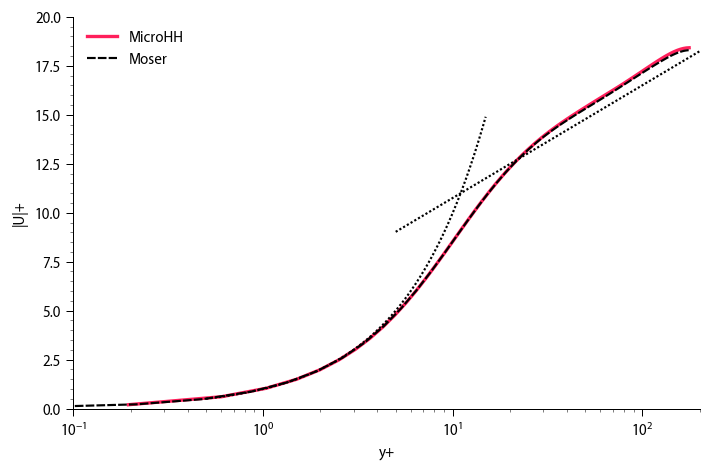

In [14]:
"""
Mean velocity profile |U|.
"""
ypluslin = np.arange(0.5, 15, 0.1)
ypluslog = np.arange(5, 800, 1)
ulin = ypluslin
ulog = 2.5 * np.log(ypluslog) + 5.

plt.figure(figsize=(6,4),layout='tight')
plt.semilogx(yplus, statm.U / ustar, '-', linewidth=2, label='MicroHH')
plt.semilogx(yplus_moser, uavg_moser, 'k--', label="Moser")
plt.semilogx(ypluslin, ulin, 'k:')
plt.semilogx(ypluslog, ulog, 'k:')
plt.xlabel('y+')
plt.ylabel('|U|+')
plt.legend()
plt.xlim(0.1, 200)
plt.ylim(0, 20)

(0.0, 3.0)

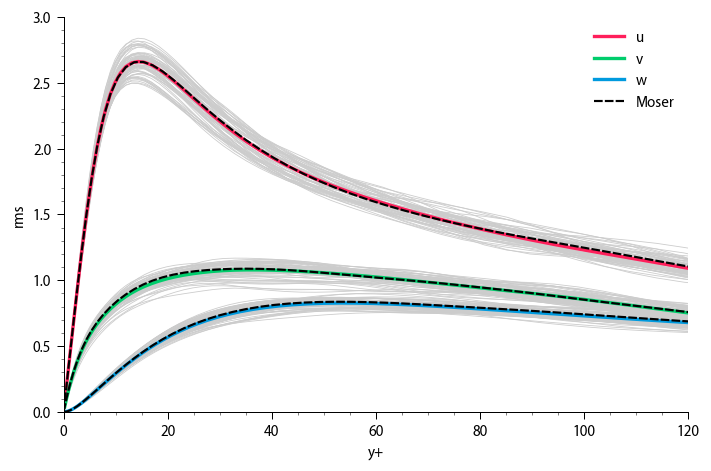

In [15]:
"""
Variances
"""
plt.figure(figsize=(6,4),layout='tight')
if plot_ensemble:
    for t in range(stat.sizes['time']):
        plt.plot(yplus,  np.sqrt(stat.u_2[t,:] / ustar**2), linewidth=0.5, color='0.8')
        plt.plot(yplus,  np.sqrt(stat.v_2[t,:] / ustar**2), linewidth=0.5, color='0.8')
        plt.plot(yplush, np.sqrt(stat.w_2[t,:] / ustar**2), linewidth=0.5, color='0.8')
plt.plot(yplus,  np.sqrt(statm.u_2 / ustar**2), linewidth=2, label='u')
plt.plot(yplus,  np.sqrt(statm.v_2 / ustar**2), linewidth=2, label='v')
plt.plot(yplush, np.sqrt(statm.w_2 / ustar**2), linewidth=2, label='w')
plt.plot(yplus_moser, np.sqrt(uvar_moser), 'k--', label="Moser")
plt.plot(yplus_moser, np.sqrt(vvar_moser), 'k--')
plt.plot(yplus_moser, np.sqrt(wvar_moser), 'k--')
plt.xlabel('y+')
plt.ylabel('rms')
plt.legend(loc=0, frameon=False)
plt.xlim(0, 120)
plt.ylim(0, 3)

(np.float64(0.0), np.float64(100.0), np.float64(-0.03), np.float64(0.04))

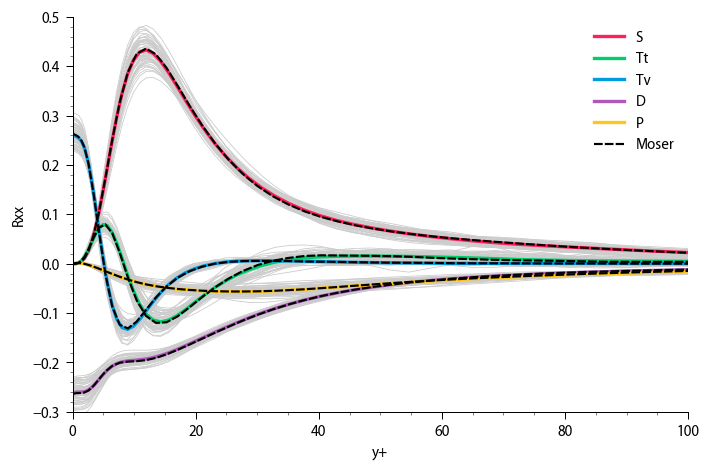

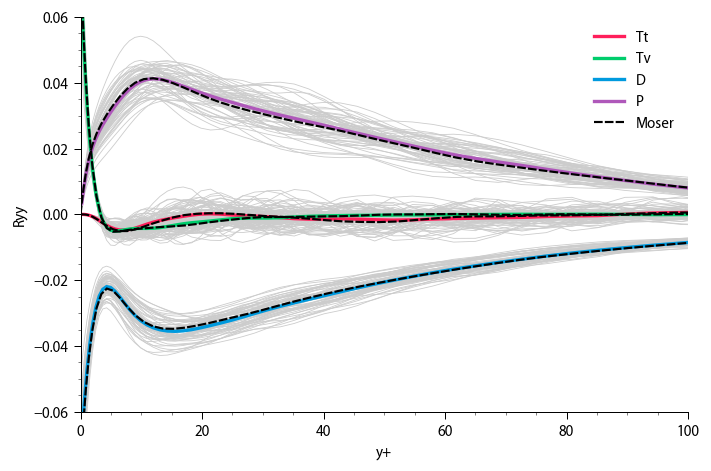

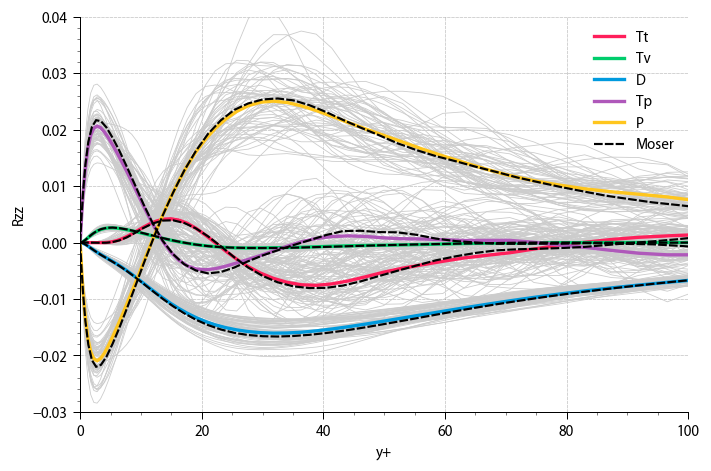

In [16]:
"""
Variance budgets.
"""
plt.figure(figsize=(6,4),layout='tight')
if plot_ensemble:
    for t in range(stat.sizes['time']):
        plt.plot(yplus, stat.u2_shear[t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.u2_turb [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.u2_visc [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.u2_diss [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.u2_rdstr[t] * visc / ustar**4, linewidth=0.5, color='0.8')
plt.plot(yplus, statm.u2_shear * visc / ustar**4., linewidth=2, label='S')
plt.plot(yplus, statm.u2_turb  * visc / ustar**4., linewidth=2, label='Tt')
plt.plot(yplus, statm.u2_visc  * visc / ustar**4., linewidth=2, label='Tv')
plt.plot(yplus, statm.u2_diss  * visc / ustar**4., linewidth=2, label='D')
plt.plot(yplus, statm.u2_rdstr * visc / ustar**4., linewidth=2, label='P')
plt.plot(yplus_moser, u2_shear_moser, 'k--', label="Moser")
plt.plot(yplus_moser, u2_turb_moser , 'k--')
plt.plot(yplus_moser, u2_visc_moser , 'k--')
plt.plot(yplus_moser, u2_diss_moser , 'k--')
plt.plot(yplus_moser, u2_rdstr_moser, 'k--')
plt.xlabel('y+')
plt.ylabel('Rxx')
plt.legend()
plt.axis([0, 100, -0.3, 0.5])


plt.figure(figsize=(6,4),layout='tight')
if plot_ensemble:
    for t in range(stat.sizes['time']):
        plt.plot(yplus, stat.v2_turb [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.v2_visc [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.v2_diss [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.v2_rdstr[t] * visc / ustar**4, linewidth=0.5, color='0.8')
plt.plot(yplus, statm.v2_turb  * visc / ustar**4, linewidth=2, label='Tt')
plt.plot(yplus, statm.v2_visc  * visc / ustar**4, linewidth=2, label='Tv')
plt.plot(yplus, statm.v2_diss  * visc / ustar**4, linewidth=2, label='D')
plt.plot(yplus, statm.v2_rdstr * visc / ustar**4, linewidth=2, label='P')
plt.plot(yplus_moser, v2_turb_moser , 'k--', label="Moser")
plt.plot(yplus_moser, v2_visc_moser , 'k--')
plt.plot(yplus_moser, v2_diss_moser , 'k--')
plt.plot(yplus_moser, v2_rdstr_moser, 'k--')
plt.xlabel('y+')
plt.ylabel('Ryy')
plt.legend(loc=0, frameon=False)
plt.axis([0, 100, -0.06, 0.06])


plt.figure(figsize=(6,4),layout='tight')
if plot_ensemble:
    for t in range(stat.sizes['time']):
        plt.plot(yplush, stat.w2_turb [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplush, stat.w2_visc [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplush, stat.w2_diss [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplush, stat.w2_pres [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplush, stat.w2_rdstr[t] * visc / ustar**4, linewidth=0.5, color='0.8')
plt.plot(yplush, statm.w2_turb  * visc / ustar**4., linewidth=2, label='Tt')
plt.plot(yplush, statm.w2_visc  * visc / ustar**4., linewidth=2, label='Tv')
plt.plot(yplush, statm.w2_diss  * visc / ustar**4., linewidth=2, label='D')
plt.plot(yplush, statm.w2_pres  * visc / ustar**4., linewidth=2, label='Tp')
plt.plot(yplush, statm.w2_rdstr * visc / ustar**4., linewidth=2, label='P')
plt.plot(yplus_moser, w2_turb_moser , 'k--', label="Moser")
plt.plot(yplus_moser, w2_visc_moser , 'k--')
plt.plot(yplus_moser, w2_diss_moser , 'k--')
plt.plot(yplus_moser, w2_pres_moser , 'k--')
plt.plot(yplus_moser, w2_rdstr_moser, 'k--')
plt.xlabel('y+')
plt.ylabel('Rzz')
plt.legend(loc=0, frameon=False)
plt.grid()
plt.axis([0, 100, -0.03, 0.04])


(np.float64(0.0), np.float64(1.0), np.float64(-1.1), np.float64(0.1))

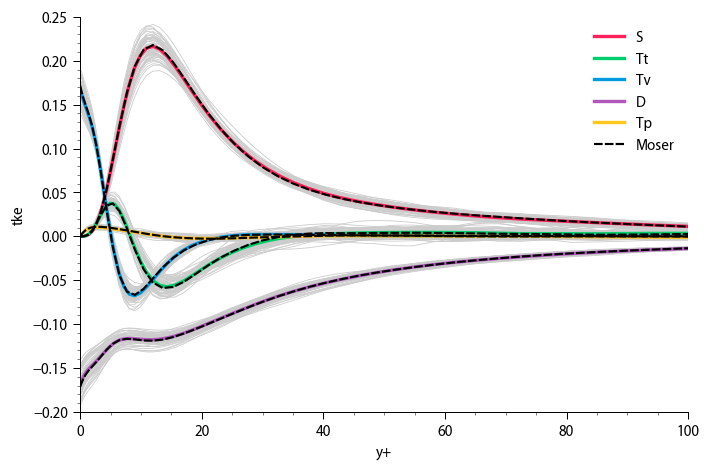

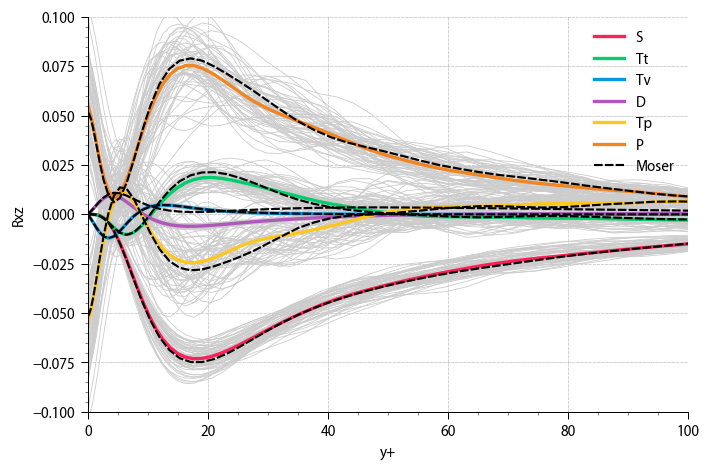

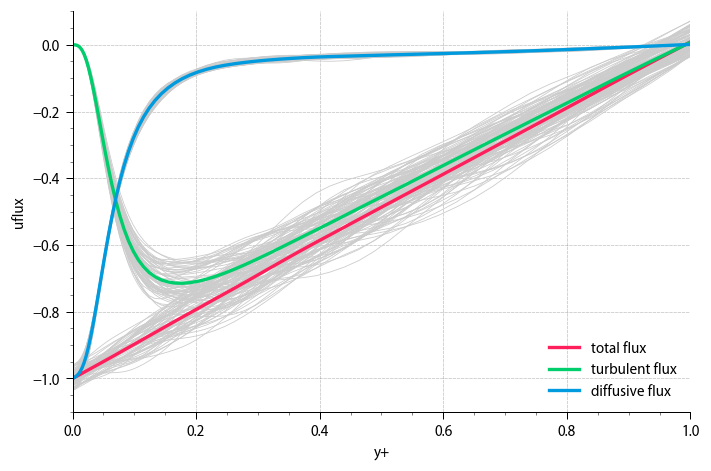

In [17]:
"""
TKE and flux budgets.
"""

plt.figure(figsize=(6,4),layout='tight')
if plot_ensemble:
    for t in range(stat.sizes['time']):
        plt.plot(yplus, stat.tke_shear[t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.tke_turb [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.tke_visc [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.tke_diss [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplus, stat.tke_pres [t] * visc / ustar**4, linewidth=0.5, color='0.8')
plt.plot(yplus, statm.tke_shear * visc / ustar**4, linewidth=2, label='S')
plt.plot(yplus, statm.tke_turb  * visc / ustar**4, linewidth=2, label='Tt')
plt.plot(yplus, statm.tke_visc  * visc / ustar**4, linewidth=2, label='Tv')
plt.plot(yplus, statm.tke_diss  * visc / ustar**4, linewidth=2, label='D')
plt.plot(yplus, statm.tke_pres  * visc / ustar**4, linewidth=2, label='Tp')
plt.plot(yplus_moser, tke_shear_moser, 'k--', label="Moser")
plt.plot(yplus_moser, tke_turb_moser , 'k--')
plt.plot(yplus_moser, tke_visc_moser , 'k--')
plt.plot(yplus_moser, tke_diss_moser , 'k--')
plt.plot(yplus_moser, tke_pres_moser , 'k--')
plt.xlabel('y+')
plt.ylabel('tke')
plt.legend()
plt.axis([0, 100, -0.2, 0.25])

plt.figure(figsize=(6,4),layout='tight')
if plot_ensemble:
    for t in range(stat.sizes['time']):
        plt.plot(yplush, stat.uw_shear[t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplush, stat.uw_turb [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplush, stat.uw_visc [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplush, stat.uw_diss [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplush, stat.uw_pres [t] * visc / ustar**4, linewidth=0.5, color='0.8')
        plt.plot(yplush, stat.uw_rdstr[t] * visc / ustar**4, linewidth=0.5, color='0.8')
plt.plot(yplush, statm.uw_shear * visc / ustar**4, linewidth=2, label='S')
plt.plot(yplush, statm.uw_turb  * visc / ustar**4, linewidth=2, label='Tt')
plt.plot(yplush, statm.uw_visc  * visc / ustar**4, linewidth=2, label='Tv')
plt.plot(yplush, statm.uw_diss  * visc / ustar**4, linewidth=2, label='D')
plt.plot(yplush, statm.uw_pres  * visc / ustar**4, linewidth=2, label='Tp')
plt.plot(yplush, statm.uw_rdstr * visc / ustar**4, linewidth=2, label='P')
plt.plot(yplus_moser, uw_shear_moser, 'k--', label="Moser")
plt.plot(yplus_moser, uw_turb_moser , 'k--')
plt.plot(yplus_moser, uw_visc_moser , 'k--')
plt.plot(yplus_moser, uw_diss_moser , 'k--')
plt.plot(yplus_moser, uw_pres_moser , 'k--')
plt.plot(yplus_moser, uw_rdstr_moser, 'k--')
plt.xlabel('y+')
plt.ylabel('Rxz')
plt.legend(loc=0, frameon=False)
plt.grid()
plt.axis([0, 100, -0.1, 0.1])

plt.figure(figsize=(6,4),layout='tight')
if plot_ensemble:
    for t in range(stat.sizes['time']):
        plt.plot(stat.zh, stat.u_flux[t,:] / ustar**2, linewidth=0.5, color='0.8')
        plt.plot(stat.zh, stat.u_w   [t,:] / ustar**2, linewidth=0.5, color='0.8')
        plt.plot(stat.zh, stat.u_diff[t,:] / ustar**2, linewidth=0.5, color='0.8')
plt.plot(stat.zh, statm.u_flux / ustar**2, linewidth=2, label='total flux')
plt.plot(stat.zh, statm.u_w    / ustar**2, linewidth=2, label='turbulent flux')
plt.plot(stat.zh, statm.u_diff / ustar**2, linewidth=2, label='diffusive flux')
plt.xlabel('y+')
plt.ylabel('uflux')
plt.legend(loc=0, frameon=False)
plt.grid()
plt.axis([0, 1, -1.1, 0.1])